## PC Session 2 Solution

# **Regression Forest**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)


We estimate the hedonic prices of used-cars using the data *used_cars.csv*. The data is restricted to BMW 320 series, Opel Astra, Mercedes C-class, VW Golf, and VW Passat. We select used-cars with a mileage between 10,000-200,000 km and an age between 1-20 years. 

We use the following variables:


|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 CHF |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional used car sellers) |
|*other_car_owner*| Number of previous caar owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*inspection*| Categorial variable for the duration until next general inspection (3 categories: new, 1-2 years, < 1 year) |
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in g/km)|
|*euro_norm*| EURO emission norm under which the car is registered |


The forest estimator will automatically incorporate interaction and non-linear terms.


## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('tidyverse','grf')

# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}

set.seed(10101) # set starting value for random number generator

print('All packages successfully installed and loaded.')


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

corrplot 0.84 loaded
Loading required package: plotrix
Loading required package: TeachingDemos


[1] "All packages successfully installed and loaded."


## Load Data Frame

We load the data frame and label the covariates. We select a subsample of 300 used-cars in order to decrease the computation time while you are testing your code. We can use the entire sample of 104,719 used cars after we are finised with programming.

In [2]:
########################  Load Data Frame  ########################

# Load data frame
data_raw <- read.csv("Data/used_cars.csv",header=TRUE, sep=",")

# Outcome Variable
outcomes <- c("first_price")

# Covariates/Features
covariates <- c("mileage", "age_car_years", "other_car_owner", "co2_em", "euro_norm", "inspection", 
                "bmw_320", "opel_astra", "mercedes_c", "vw_golf", "vw_passat", "diesel", 
                "private_seller", "guarantee", "maintenance_cert", "pm_green") 

all_variables <- c(outcomes, covariates)

# Selection of Subsample size, max. 104,721 observations
# Select smaller subsample to decrease computation time
n_obs <- 300
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

print('Data frame successfully loaded.')


[1] "Data frame successfully loaded."


## Descriptive Statistics

### Means and Standard Deviations

In [3]:
########################  Table with Descriptive Statistics  ########################

desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
          select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=1))


                        Mean       Stdev Minimum    Maximum nobs
first_price             14.7         6.5     3.2 3.8100e+01  300
mileage                102.2        50.3    10.0 2.0000e+02  300
mileage2             12971.1     10778.5   100.0 4.0000e+04  300
mileage3           1851120.6   2057807.8  1000.0 8.0000e+06  300
mileage4         284038226.0 387153789.8 10000.0 1.6000e+09  300
age_car_years            4.9         2.7     1.1 1.4000e+01  300
age_car_years2          31.6        36.9     1.2 1.9600e+02  300
age_car_years3         252.4       455.3     1.3 2.7440e+03  300
age_car_years4        2355.8      5683.3     1.5 3.8416e+04  300
other_car_owner          1.1         0.7     0.0 3.0000e+00  300
co2_em                 140.4        26.5    92.0 2.3800e+02  300
euro_1                   0.0         0.0     0.0 0.0000e+00  300
euro_2                   0.0         0.0     0.0 0.0000e+00  300
euro_3                   0.0         0.1     0.0 1.0000e+00  300
euro_4                   

## Take Hold-Out-Sample 

We want to compare the relative prediction power of different estimation procedures based on the out-of-sample MSE and $R^2$. For this purpose, we create an hold-out-sample.

In [5]:
########################  Take Hold-Out-Sample  ########################

df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
first_price_hold_out <- as.matrix(df_hold_out[,1])

# Covariates/Features
covariates_obs <- as.matrix(df_obs[,c(2:ncol(df_obs))])
covariates_hold_out <- as.matrix(df_hold_out[,c(2:ncol(df_hold_out))])

print('The data is now ready for your first analysis!')


[1] "The data is now ready for your first analysis!"


# Random Forest

The honest random forest computes many honest trees using different subsamples and subsets of the covariates. Then it reports the final_price predicted using the average of all honest trees.

In [6]:
########################  Random Forest  ######################## 

forest <- regression_forest(covariates_obs, first_price_obs,
                            sample.fraction = 0.5, min.node.size = 1,
                            mtry = floor(1/2*ncol(covariates_obs)),
                            num.trees = 500,
                            honesty = TRUE, honesty.fraction = 0.5)


fit_in <- predict(forest)$predictions
fit_out <- predict(forest, newdata =covariates_hold_out)$predictions


Evaluate the in- and out-of-sample performance using MSE and $R^2$.

In [ ]:
# In-sample performance measures
mse1_in <- round(mean((first_price_obs - fit_in)^2),digits=3)
rsquared_in <- round(1-mean((first_price_obs - fit_in)^2)/mean((first_price_obs - mean(first_price_obs))^2),digits=3)
print(paste0("In-Sample MSE Forest: ", mse1_in))
print(paste0("In-Sample R-squared Forest: ", rsquared_in))

# Out-of-sample performance measures
mse1_out <- round(mean((first_price_hold_out - fit_out)^2),digits=3)
rsquared_out <- round(1-mean((first_price_hold_out - fit_out)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)
print(paste0("Out-of-Sample MSE Forest: ", mse1_out))
print(paste0("Out-of-Sample R-squared Forest: ", rsquared_out))

It is difficult the interpret the structure of an random forest. We can report the number of splits based on different covariates. But we have to interprete this with caution, because the covariates might be correlated.

[1] "Lambda minimising CV-MSE: 0.12480896"
[1] "Lambda 1 standard error rule: 0.38114854"
[1] "Number of selected covariates (lambd.min): 56"
[1] "Number of selected covariates (lambd.1se): 15"


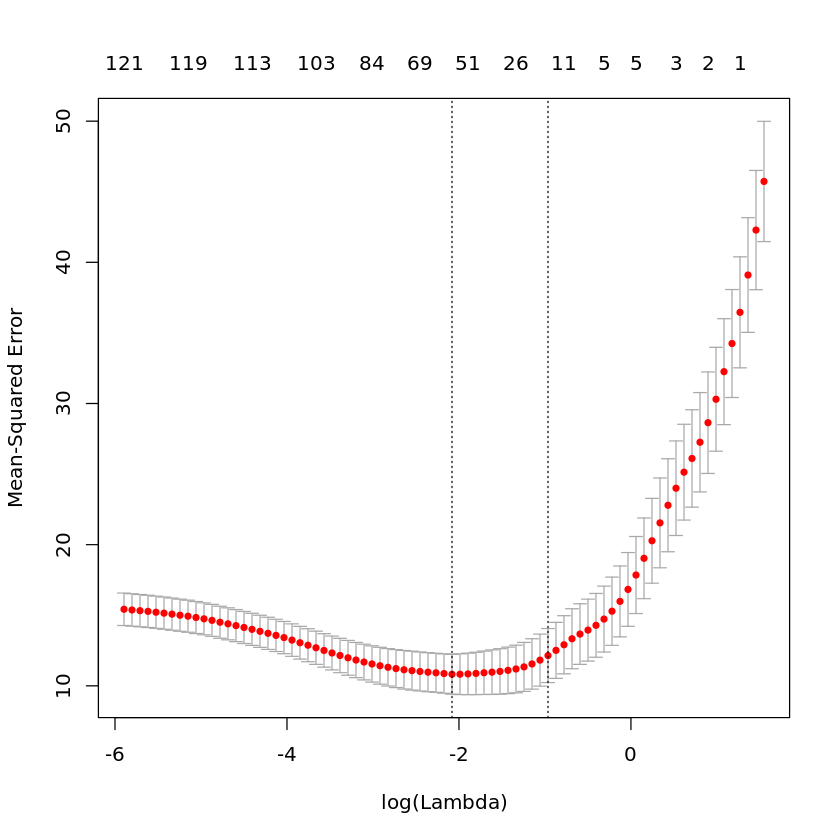

In [9]:
vars <- split_frequencies(forest, max.depth = 4)
colnames(vars) <- covariates
print(vars)

sum(vars[1,])
sum(vars[2,])
sum(vars[3,])
sum(vars[4,])

Random forests have many tuning parameters. Often the choice of the tuning parameters do not matter very much when we use many trees to grow the forest. Therefore, the forest size is an important tuning parameter for random forests. A plot of the RMSE by forest size can help us to select the forest size. Usually, we select a fairly large forest.

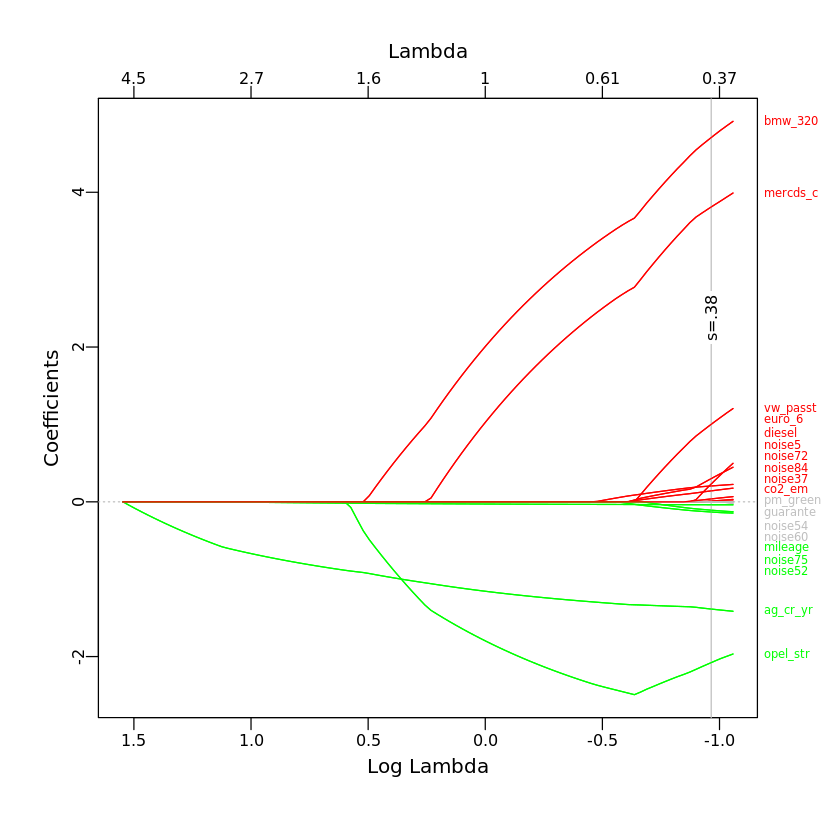

In [23]:
########################  Select tuning parameters for forest  ######################## 

#for_sizes = c(1,5, 10,15, 20,25,50,100,150,200,250, 300,350, 400, 450, 500, 1000, 1500, 2000, 3000, 4000, 5000, 10000)
for_sizes = c(1,5, 10,15, 20,25,50,100,150,200,250, 300,350, 400, 450, 500) # Because of computation time we consider only forests with 500 trees. At home you can consider larger forests.
auc <- matrix(NA,nrow=length(for_sizes),ncol=3)
ctr <- 0
for (n in for_sizes){
  ctr <- ctr + 1
  auc[ctr,1] <- n
  
    forest <- regression_forest(covariates_obs, first_price_obs,
                            sample.fraction = 0.5, min.node.size = 1,
                            mtry = floor(1/2*ncol(covariates_obs)),
                            num.trees = n,
                            honesty = TRUE, honesty.fraction = 0.5)
  
  # Predict prices in hold-out-sample
  pred_forest <- predict(forest, newdata = baseline_covariates_hold_out)
  rmse_forest <- round(sqrt(mean((first_price_hold_out - pred_forest$predictions)^2)),digits=3)
  auc[ctr,2] <- rmse_forest
  if (ctr >1) {
    auc[ctr,3] <- rmse_forest-auc[ctr-1,2]
  }
}

plot(auc[,1], auc[,2], main="Tuning of forest size", xlab="Number of trees in forest ", ylab="RMSE", pch=19)
nls_fit <- lm(auc[,2] ~  auc[,1] + I(auc[,1]^(1/2)) + I(auc[,1]^2) + I(auc[,1]^3) + I(log(auc[,1])))
lines(auc[,1], predict(nls_fit), col = "red")

plot(auc[c(2:nrow(auc)),1], auc[c(2:nrow(auc)),3], main="Tuning of forest size", xlab="Number of trees in forest ", ylab="Delta RMSE", pch=19)
nls_fit <- lm(auc[c(2:nrow(auc)),3] ~  auc[c(2:nrow(auc)),1] + I(auc[c(2:nrow(auc)),1]^(1/2)) + I(auc[c(2:nrow(auc)),1]^2) + I(auc[c(2:nrow(auc)),1]^3) + I(log(auc[c(2:nrow(auc)),1])))
lines(auc[c(2:nrow(auc)),1], predict(nls_fit), col = "red")
abline(h=0)





# Extra Exercises:

1. ada
2. addad
3. adas